In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

sns.set_context('talk')

# 1. Business Understanding

Data mining objectives:
- identify key features that are associated with cancelled bookings
- create a model to predict booking cancellation

Aim: $\geq$ 80% accuracy

# 2. Data Understanding

## 2.1. Data Collection

Source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

## 2.2. Data Description

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('business-data-understanding').getOrCreate()

/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/cloudpickle.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if obj.__module__ is "__builtin__":


In [3]:
# Import data with automatically configured schema
df_h1 = spark.read.csv('H1.csv', header=True, inferSchema=True)
df_h2 = spark.read.csv('H2.csv', header=True, inferSchema=True)

### Preview of the dataset

In [4]:
df_h1.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Depos

In [5]:
df_h2.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: string (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Deposi

In [6]:
df_h1.head(1)[0].asDict()

{'IsCanceled': 0,
 'LeadTime': 342,
 'ArrivalDateYear': 2015,
 'ArrivalDateMonth': 'July',
 'ArrivalDateWeekNumber': 27,
 'ArrivalDateDayOfMonth': 1,
 'StaysInWeekendNights': 0,
 'StaysInWeekNights': 0,
 'Adults': 2,
 'Children': 0,
 'Babies': 0,
 'Meal': 'BB       ',
 'Country': 'PRT',
 'MarketSegment': 'Direct',
 'DistributionChannel': 'Direct',
 'IsRepeatedGuest': 0.0,
 'PreviousCancellations': 0,
 'PreviousBookingsNotCanceled': 0,
 'ReservedRoomType': 'C               ',
 'AssignedRoomType': 'C               ',
 'BookingChanges': 3,
 'DepositType': 'No Deposit     ',
 'Agent': '       NULL',
 'Company': '       NULL',
 'DaysInWaitingList': 0,
 'CustomerType': 'Transient',
 'ADR': 0.0,
 'RequiredCarParkingSpaces': 0,
 'TotalOfSpecialRequests': 0,
 'ReservationStatus': 'Check-Out',
 'ReservationStatusDate': datetime.datetime(2015, 7, 1, 0, 0)}

In [7]:
df_h2.head(1)[0].asDict()

{'IsCanceled': 0,
 'LeadTime': 6,
 'ArrivalDateYear': 2015,
 'ArrivalDateMonth': 'July',
 'ArrivalDateWeekNumber': 27,
 'ArrivalDateDayOfMonth': 1,
 'StaysInWeekendNights': 0,
 'StaysInWeekNights': 2,
 'Adults': 1,
 'Children': '0',
 'Babies': 0,
 'Meal': 'HB       ',
 'Country': 'PRT',
 'MarketSegment': 'Offline TA/TO',
 'DistributionChannel': 'TA/TO',
 'IsRepeatedGuest': 0.0,
 'PreviousCancellations': 0,
 'PreviousBookingsNotCanceled': 0,
 'ReservedRoomType': 'A               ',
 'AssignedRoomType': 'A               ',
 'BookingChanges': 0,
 'DepositType': 'No Deposit     ',
 'Agent': '          6',
 'Company': '       NULL',
 'DaysInWaitingList': 0,
 'CustomerType': 'Transient',
 'ADR': 0.0,
 'RequiredCarParkingSpaces': 0,
 'TotalOfSpecialRequests': 0,
 'ReservationStatus': 'Check-Out',
 'ReservationStatusDate': datetime.datetime(2015, 7, 3, 0, 0)}

### Generate summary statistics

We only compute summary of numeric columns that are considered meaningful in our analysis.

In [8]:
excluded_cols = [
    'IsCanceled','ArrivalDateYear','ArrivalDateWeekNumber',
    'ArrivalDateDayOfMonth','IsRepeatedGuest','BookingChanges'
]

numeric_cols = [item[0] for item in df_h1.dtypes if (item[1] != 'string') & (item[1] != 'timestamp')]
selected_cols = list(set(numeric_cols) - set(excluded_cols))

## generate summary statistics using describe()
## returns count, mean, stddev, min, max
df_desc_h1 = df_h1.select(selected_cols).describe().toPandas().set_index("summary").transpose()
df_desc_h2 = df_h2.select(selected_cols).describe().toPandas().set_index("summary").transpose()

In [9]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_h1.createOrReplaceTempView('df_h1')
df_h2.createOrReplaceTempView('df_h2')

h1_median = {}
h2_median = {}

## calculate median of the relevant columns
for src in ['df_h1', 'df_h2']:
    for col in selected_cols:
        MEDIAN_QUERY = "select percentile_approx({0}, 0.5) as {0} from {1}".format(col, src)
        val = sql_con.sql(MEDIAN_QUERY).collect()[0][0]
        if 'h1' in src:
            h1_median[col] = val
        else:
            h2_median[col] = val
            
df_median_h1 = pd.DataFrame(h1_median, index=['median']).transpose()
df_median_h2 = pd.DataFrame(h2_median, index=['median']).transpose()

In [10]:
## combine with describe() results
df_desc_ext_h1 = pd.merge(
    df_desc_h1,
    df_median_h1,
    left_index = True,
    right_index = True
)

df_desc_ext_h2 = pd.merge(
    df_desc_h2,
    df_median_h2,
    left_index = True,
    right_index = True
)

display(df_desc_ext_h1)
display(df_desc_ext_h2)

,count,mean,stddev,min,max,median
Adults,40060,1.8671492760858712,0.6972854908686615,0,55,2.0
StaysInWeekendNights,40060,1.1898152770843735,1.1478121986554535,0,19,1.0
PreviousBookingsNotCanceled,40060,0.1464553170244633,1.0019545373196967,0,30,0.0
PreviousCancellations,40060,0.10172241637543684,1.335115273286218,0,26,0.0
StaysInWeekNights,40060,3.1287319021467797,2.4613294130121455,0,50,3.0
TotalOfSpecialRequests,40060,0.6197703444832751,0.8139295959314988,0,5,0.0
LeadTime,40060,92.67568647029456,97.28531530975067,0,737,57.0
Children,40060,0.12868197703444834,0.4451952010391827,0,10,0.0
ADR,40060,94.95292960559225,61.44241797380695,-6.38,508.0,75.0
Babies,40060,0.013904143784323515,0.11899789100299267,0,2,0.0


,count,mean,stddev,min,max,median
Adults,79330,1.8509769318038574,0.5092923075822537,0,4,2.0
StaysInWeekendNights,79330,0.7951846716248582,0.8850263827567242,0,16,1.0
PreviousBookingsNotCanceled,79330,0.13237110802974916,1.6934106009564729,0,72,0.0
PreviousCancellations,79330,0.07974284633808143,0.41547221430867254,0,21,0.0
StaysInWeekNights,79330,2.1829572671120636,1.456416186248435,0,41,2.0
TotalOfSpecialRequests,79330,0.546917937728476,0.7807762224113686,0,5,0.0
LeadTime,79330,109.73572419009201,110.94852576365864,0,629,74.0
Children,79330,0.09136979048483473,0.37217686997893606,0,NA,0.0
ADR,79330,105.3044653977023,43.60295383709472,0.0,5400.0,99.9
Babies,79330,0.0049413840917685616,0.08432334146198825,0,10,0.0


In [11]:
## clean memory
del df_desc_ext_h1, df_desc_ext_h2, df_desc_h1, df_desc_h2, df_median_h1, df_median_h2

## 2.3. Data Exploration

### Distribution by reservation status

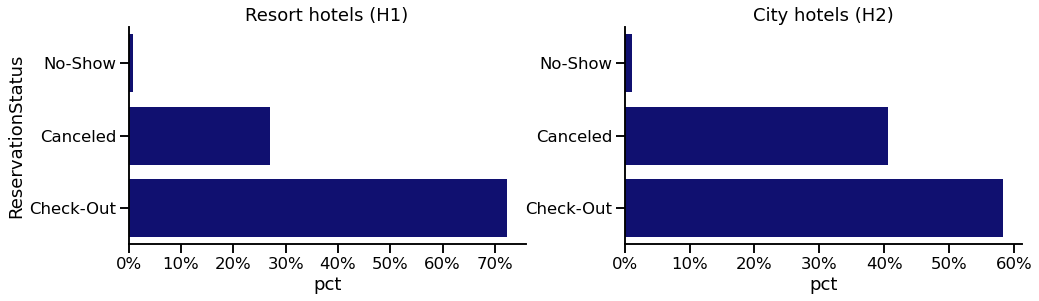

In [12]:
h1_resv_status = df_h1.groupBy('ReservationStatus').count().orderBy('count').toPandas()
h1_resv_status['pct'] = h1_resv_status['count'] / h1_resv_status['count'].sum()

h2_resv_status = df_h2.groupBy('ReservationStatus').count().orderBy('count').toPandas()
h2_resv_status['pct'] = h2_resv_status['count'] / h2_resv_status['count'].sum()

f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.barplot(
    data = h1_resv_status,
    y = 'ReservationStatus',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[0]
)
ax[0].set_title('Resort hotels (H1)')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = h2_resv_status,
    y = 'ReservationStatus',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[1]
)
ax[1].set_title('City hotels (H2)')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_ylabel('')

sns.despine();

In [13]:
del h1_resv_status, h2_resv_status

### Distribution by country

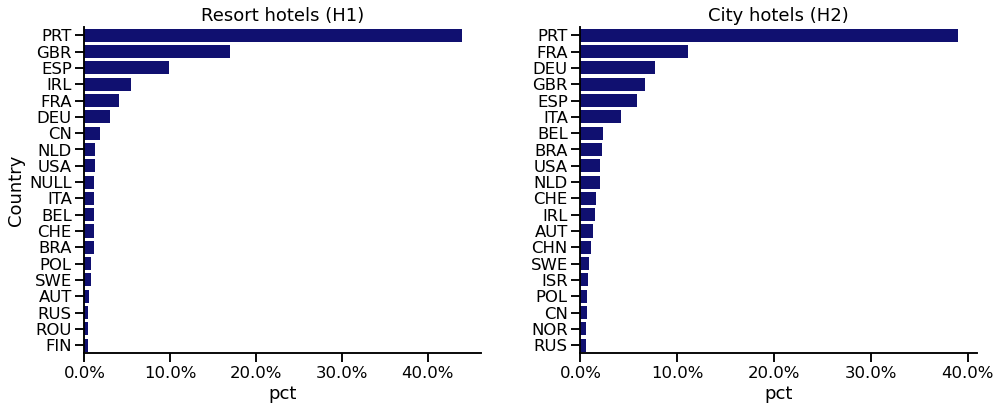

In [14]:
h1_country = df_h1.groupBy('Country').count().orderBy('count', ascending = False).toPandas()
h1_country['pct'] = h1_country['count'] / h1_country['count'].sum()

h2_country = df_h2.groupBy('Country').count().orderBy('count', ascending = False).toPandas()
h2_country['pct'] = h2_country['count'] / h2_country['count'].sum()

n = 20
f, ax = plt.subplots(figsize = (16, 6), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.barplot(
    data = h1_country.head(n),
    y = 'Country',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[0]
)
ax[0].set_title('Resort hotels (H1)')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

sns.barplot(
    data = h2_country.head(n),
    y = 'Country',
    x = 'pct',
    orient = 'h',
    color = 'navy',
    ax = ax[1]
)
ax[1].set_title('City hotels (H2)')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_ylabel('')

sns.despine();

In [15]:
del h1_country, h2_country

### Cancelled bookings by week of year

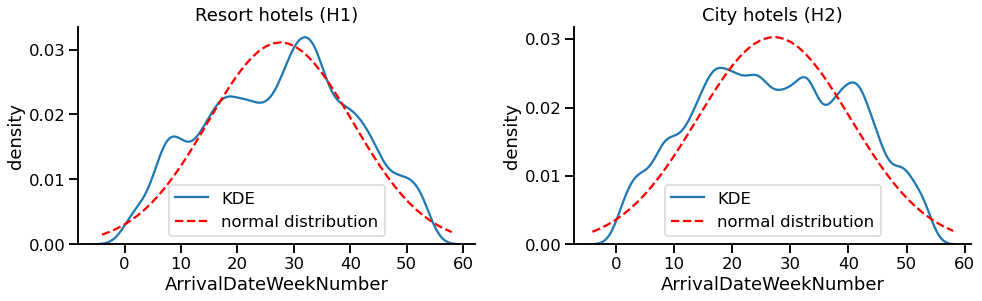

In [16]:
from scipy.stats import norm

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

## fit a normal distribution
x1 = df_h1.filter('IsCanceled == 1').select('ArrivalDateWeekNumber').toPandas()['ArrivalDateWeekNumber']
## set x-axis value range
support = np.linspace(np.min(x1) - 5, np.max(x1) + 5)

sns.kdeplot(
    x1,
    ax = ax[0],
    label = 'KDE'
);
ax[0].plot(
    support,
    norm.pdf(support, *norm.fit(x1)),
    linestyle = '--',
    color = 'red',
    label = 'normal distribution'
)

x2 = df_h2.filter('IsCanceled == 1').select('ArrivalDateWeekNumber').toPandas()['ArrivalDateWeekNumber'] 
support = np.linspace(np.min(x2) - 5, np.max(x2) + 5)
sns.kdeplot(
    x2,
    ax = ax[1],
    label = 'KDE'
);
ax[1].plot(
    support,
    norm.pdf(support, *norm.fit(x2)),
    linestyle = '--',
    color = 'red',
    label = 'normal distribution'
)

ax[0].set_title("Resort hotels (H1)")
ax[1].set_title("City hotels (H2)")
ax[0].set_ylabel('density')
ax[1].set_ylabel('density')

ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
sns.despine();

### Cancelled bookings by day of month

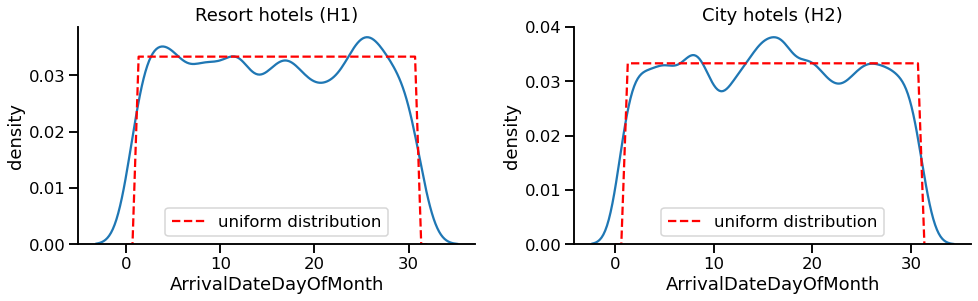

In [17]:
from scipy.stats import uniform

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

## fit a reference distribution
x1 = df_h1.filter('IsCanceled == 1').select('ArrivalDateDayOfMonth').toPandas()['ArrivalDateDayOfMonth']
## set x-axis value range
support = np.linspace(np.min(x1)-1, np.max(x1)+1)

sns.kdeplot(
    x1,
    ax = ax[0]
);
## plot the reference distribution
ax[0].plot(
    support,
    uniform.pdf(support, *uniform.fit(x1)),
    linestyle = '--',
    color = 'red',
    label = 'uniform distribution'
)

## fit a reference distribution
x2 = df_h2.filter('IsCanceled == 1').select('ArrivalDateDayOfMonth').toPandas()['ArrivalDateDayOfMonth']
## set x-axis value range
support = np.linspace(np.min(x2)-1, np.max(x2)+1)

sns.kdeplot(
    x2,
    ax = ax[1]
);
## plot the reference distribution
ax[1].plot(
    support,
    uniform.pdf(support, *uniform.fit(x2)),
    linestyle = '--',
    color = 'red',
    label = 'uniform distribution'
)

ax[0].set_title("Resort hotels (H1)")
ax[1].set_title("City hotels (H2)")
ax[0].set_ylabel('density')
ax[1].set_ylabel('density')
ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
sns.despine();

In [18]:
## remove objects from memory
del x1, x2

### ADR 

#### ADR based on cancellation status

H2 dataset has a record with extremely high ADR.

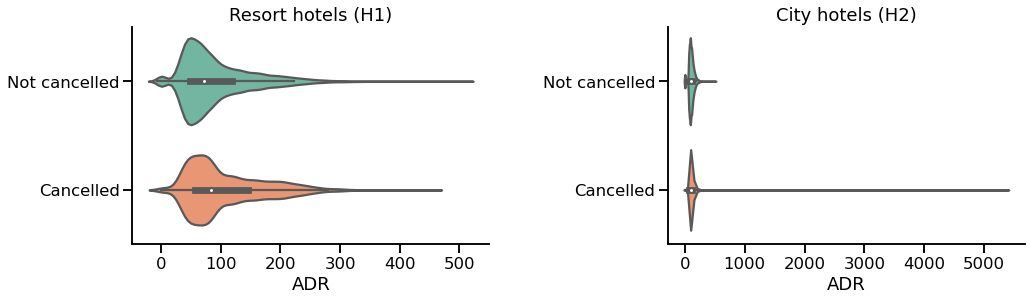

In [19]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.violinplot(
    data = df_h1.select(['IsCanceled','ADR']).toPandas(),
    y = 'IsCanceled',
    x = 'ADR',
    orient = 'h',
    palette = 'Set2',
    ax = ax[0]
)
ax[0].set_title("Resort hotels (H1)")
ax[0].set_yticklabels(['Not cancelled','Cancelled'])
ax[0].set_ylabel('')

sns.violinplot(
    data = df_h2.select(['IsCanceled','ADR']).toPandas(),
    y = 'IsCanceled',
    x = 'ADR',
    orient = 'h',
    palette = 'Set2',
    ax = ax[1]
)
ax[1].set_title("City hotels (H2)")
ax[1].set_yticklabels(['Not cancelled','Cancelled'])
ax[1].set_ylabel('')
sns.despine();

#### ADR by distribution channel

An outlier is found on TA/TO distribution channel.

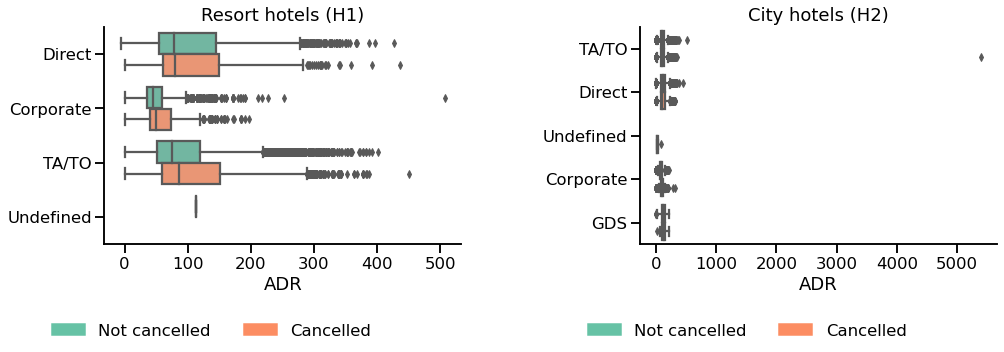

In [20]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .5)

COLOR_PALETTE = 'Set2'
patch_setting = [
    mpatches.Patch(color = sns.color_palette(COLOR_PALETTE)[0]), 
    mpatches.Patch(color = sns.color_palette(COLOR_PALETTE)[1])
]

sns.boxplot(
    data = df_h1.select(['DistributionChannel','IsCanceled','ADR']).toPandas(),
    y = 'DistributionChannel',
    x = 'ADR',
    orient = 'h',
    hue = 'IsCanceled',
    palette = COLOR_PALETTE,
    ax = ax[0]
)
ax[0].set_title("Resort hotels (H1)")
ax[0].set_ylabel('')
ax[0].legend(
    loc = 'lower center',
    handles = patch_setting,
    labels = ['Not cancelled','Cancelled'], 
    bbox_to_anchor = [0.3,-.5], 
    ncol = 2,
    frameon = False
)

sns.boxplot(
    data = df_h2.select(['DistributionChannel','IsCanceled','ADR']).toPandas(),
    y = 'DistributionChannel',
    x = 'ADR',
    orient = 'h',
    hue = 'IsCanceled',
    palette = COLOR_PALETTE,
    ax = ax[1]
)
ax[1].set_title("City hotels (H2)")
ax[1].set_ylabel('')
ax[1].legend(
    loc = 'lower center',
    handles = patch_setting,
    labels = ['Not cancelled','Cancelled'], 
    bbox_to_anchor = [0.3,-.5], 
    ncol = 2,
    frameon = False
)
sns.despine();

#### ADR, LeadTime, DaysInWaitingList by distribution channel and market segment

In [21]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_h1.createOrReplaceTempView('df_h1')
df_h2.createOrReplaceTempView('df_h2')

for src in ['df_h1', 'df_h2']:
    QUERY = """
        select 
          DistributionChannel, 
          MarketSegment,
          count(*) as count,
          avg(ADR) as ADR_mean,
          percentile_approx(ADR, 0.5) as ADR_median,
          avg(LeadTime) as LeadTime_mean,
          percentile_approx(LeadTime, 0.5) as LeadTime_median,
          avg(DaysInWaitingList) as DaysInWaitingList_mean,
          percentile_approx(DaysInWaitingList, 0.5) as DaysInWaitingList_median
        from {}
        group by 1,2
    """.format(src)

    result = sql_con.sql(QUERY).toPandas()
    print(src)
    display(result.set_index(['DistributionChannel','MarketSegment']).style.format('{:,.2f}'))

df_h1


df_h2


In [22]:
## remove objects from memory
del result

### Lead Time

#### Lead Time by Cancellation Status

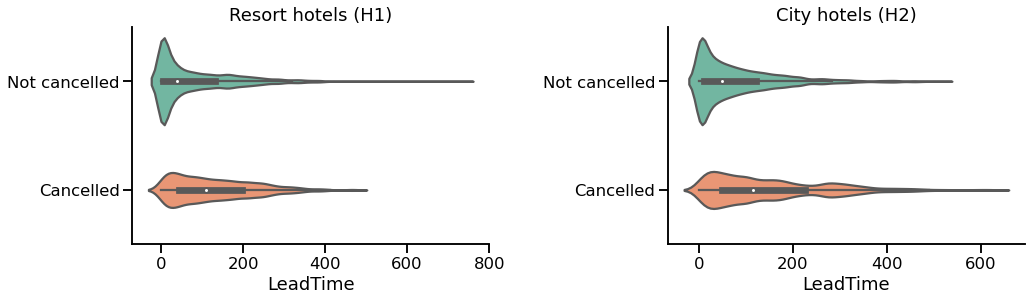

In [23]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .5)

sns.violinplot(
    data = df_h1.select(['IsCanceled','LeadTime']).toPandas(),
    y = 'IsCanceled',
    x = 'LeadTime',
    orient = 'h',
    palette = 'Set2',
    ax = ax[0]
)
ax[0].set_title("Resort hotels (H1)")
ax[0].set_yticklabels(['Not cancelled','Cancelled'])
ax[0].set_ylabel('')

sns.violinplot(
    data = df_h2.select(['IsCanceled','LeadTime']).toPandas(),
    y = 'IsCanceled',
    x = 'LeadTime',
    orient = 'h',
    palette = 'Set2',
    ax = ax[1]
)
ax[1].set_title("City hotels (H2)")
ax[1].set_yticklabels(['Not cancelled','Cancelled'])
ax[1].set_ylabel('')
sns.despine();

#### Lead Time by Distribution Channel

Cancelled reservations tend to have a longer lead time. TA/TO has a wider lead time range compared to other distribution channels.

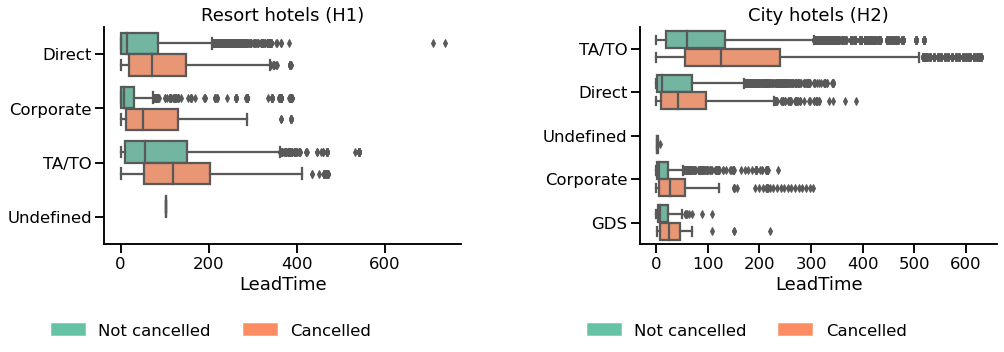

In [24]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .5)

COLOR_PALETTE = 'Set2'
patch_setting = [
    mpatches.Patch(color = sns.color_palette(COLOR_PALETTE)[0]), 
    mpatches.Patch(color = sns.color_palette(COLOR_PALETTE)[1])
]

sns.boxplot(
    data = df_h1.select(['DistributionChannel','IsCanceled','LeadTime']).toPandas(),
    y = 'DistributionChannel',
    x = 'LeadTime',
    orient = 'h',
    hue = 'IsCanceled',
    palette = COLOR_PALETTE,
    ax = ax[0]
)
ax[0].set_title("Resort hotels (H1)")
ax[0].set_ylabel('')
ax[0].legend(
    loc = 'lower center',
    handles = patch_setting,
    labels = ['Not cancelled','Cancelled'], 
    bbox_to_anchor = [0.3,-.5], 
    ncol = 2,
    frameon = False
)

sns.boxplot(
    data = df_h2.select(['DistributionChannel','IsCanceled','LeadTime']).toPandas(),
    y = 'DistributionChannel',
    x = 'LeadTime',
    orient = 'h',
    hue = 'IsCanceled',
    palette = COLOR_PALETTE,
    ax = ax[1]
)
ax[1].set_title("City hotels (H2)")
ax[1].set_ylabel('')
ax[1].legend(
    loc = 'lower center',
    handles = patch_setting,
    labels = ['Not cancelled','Cancelled'], 
    bbox_to_anchor = [0.3,-.5], 
    ncol = 2,
    frameon = False
)
sns.despine();

### Correlation of numeric values

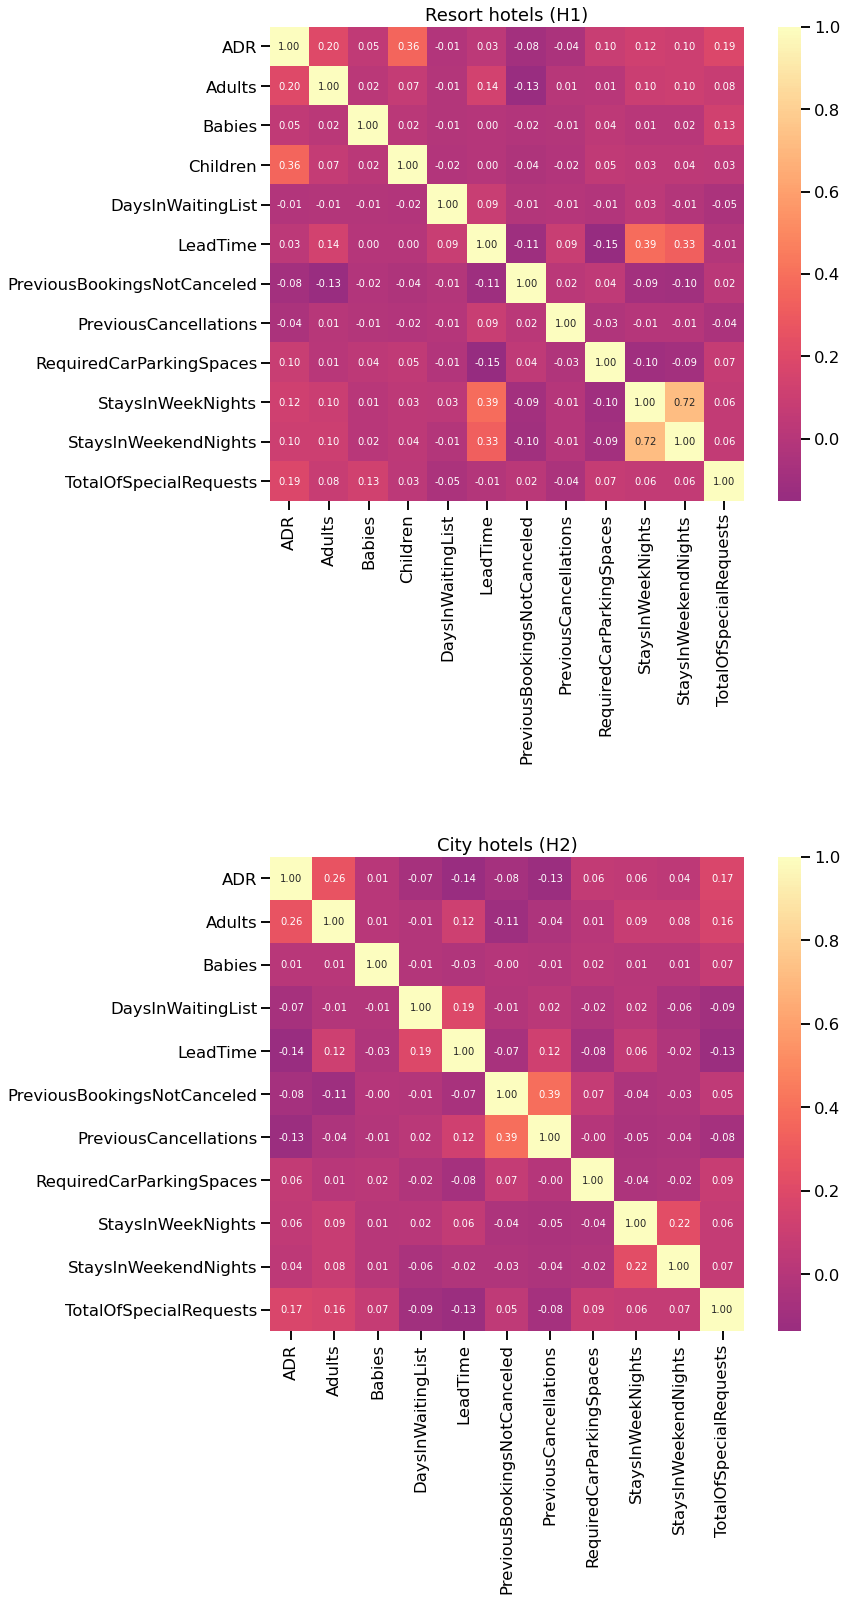

In [25]:
f, ax = plt.subplots(figsize = (12, 24), nrows = 2)
plt.subplots_adjust(hspace = .75)

## H1
sns.heatmap(
    df_h1.select(sorted(selected_cols)).toPandas().corr(),
    center = 0,
    square = True,
    annot = True,
    fmt = '.2f',
    annot_kws = {'size': 10},
    cmap = 'magma',
    ax = ax[0]
);
ax[0].set_title("Resort hotels (H1)")

## H2
sns.heatmap(
    df_h2.select(sorted(selected_cols)).toPandas().corr(),
    center = 0,
    square = True,
    annot = True,
    fmt = '.2f',
    annot_kws = {'size': 10},
    cmap = 'magma',
    ax = ax[1]
);
ax[1].set_title("City hotels (H2)");

### Distribution of numeric values

Resort hotels (H1)


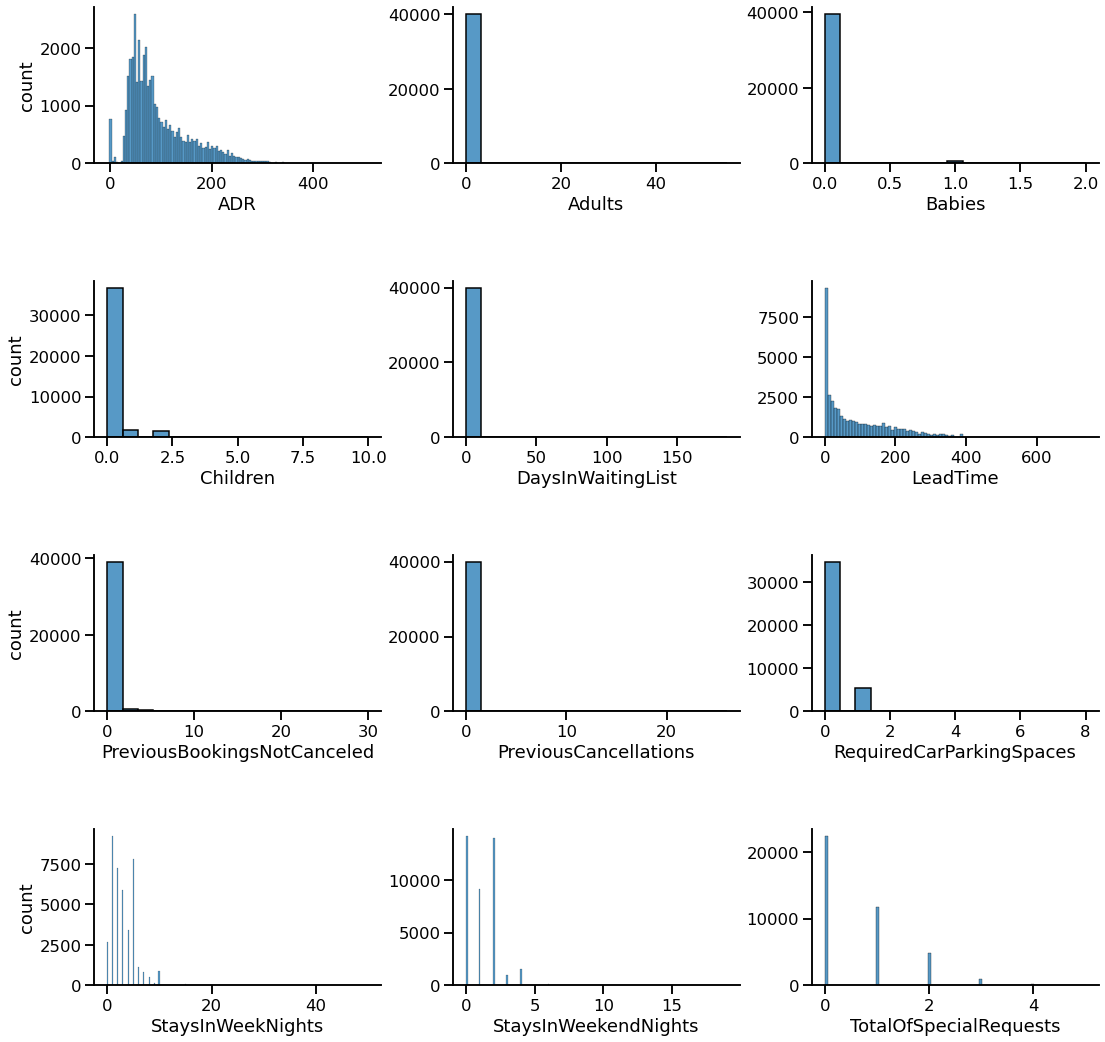

In [26]:
print("Resort hotels (H1)")

f, ax = plt.subplots(figsize = (18, 18), ncols = 3, nrows = 4)
plt.subplots_adjust(wspace = .25, hspace = .75)

i = 0
j = 0
for col in sorted(selected_cols):
    sns.histplot(
        df_h1.select(col).toPandas(),
        legend = False,
        ax = ax[i][j]
    )
    ax[i][j].set_xlabel(col)
    
    if j == 0:
        ax[i][j].set_ylabel('count')
    else:
        ax[i][j].set_ylabel('')
    
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1
        
sns.despine();

City hotels (H2)


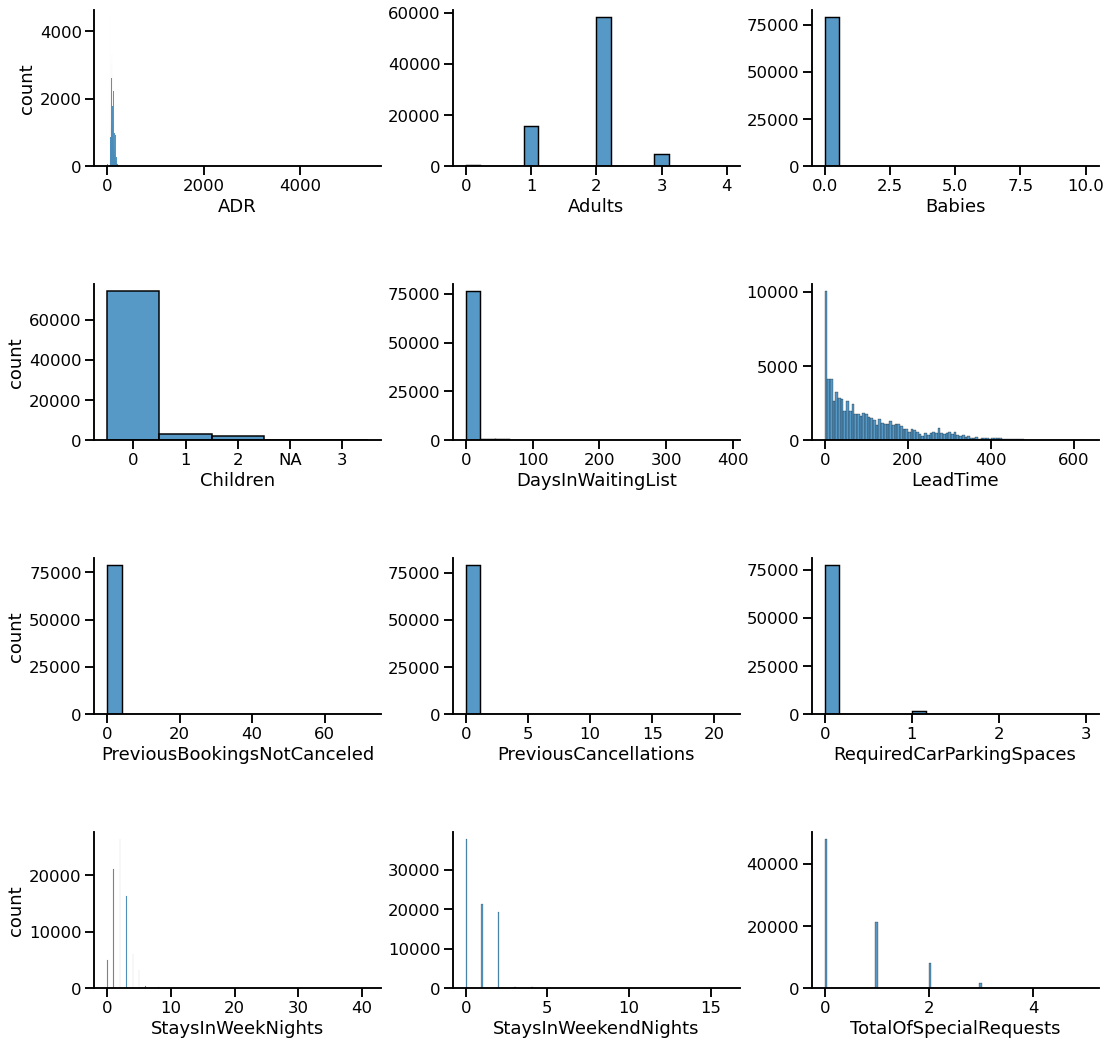

In [27]:
print("City hotels (H2)")

f, ax = plt.subplots(figsize = (18, 18), ncols = 3, nrows = 4)
plt.subplots_adjust(wspace = .25, hspace = .75)

i = 0
j = 0
for col in sorted(selected_cols):
    sns.histplot(
        ## ignore NA
        df_h2.na.drop(subset = col).select(col).toPandas()[col],
        legend = False,
        ax = ax[i][j]
    )
    ax[i][j].set_xlabel(col)
    
    if j == 0:
        ax[i][j].set_ylabel('count')
    else:
        ax[i][j].set_ylabel('')
    
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1
        
sns.despine();

## 2.4. Data Quality Assessment

### 2.4.1. Inconsistent coding scheme

At a glance, there is no inconsistent coding scheme in both datasets. However, actually the Undefined Meal value refers to the same meaning of SC (refer to the metadata explanation). We'll sort them out on the Data Cleaning part.

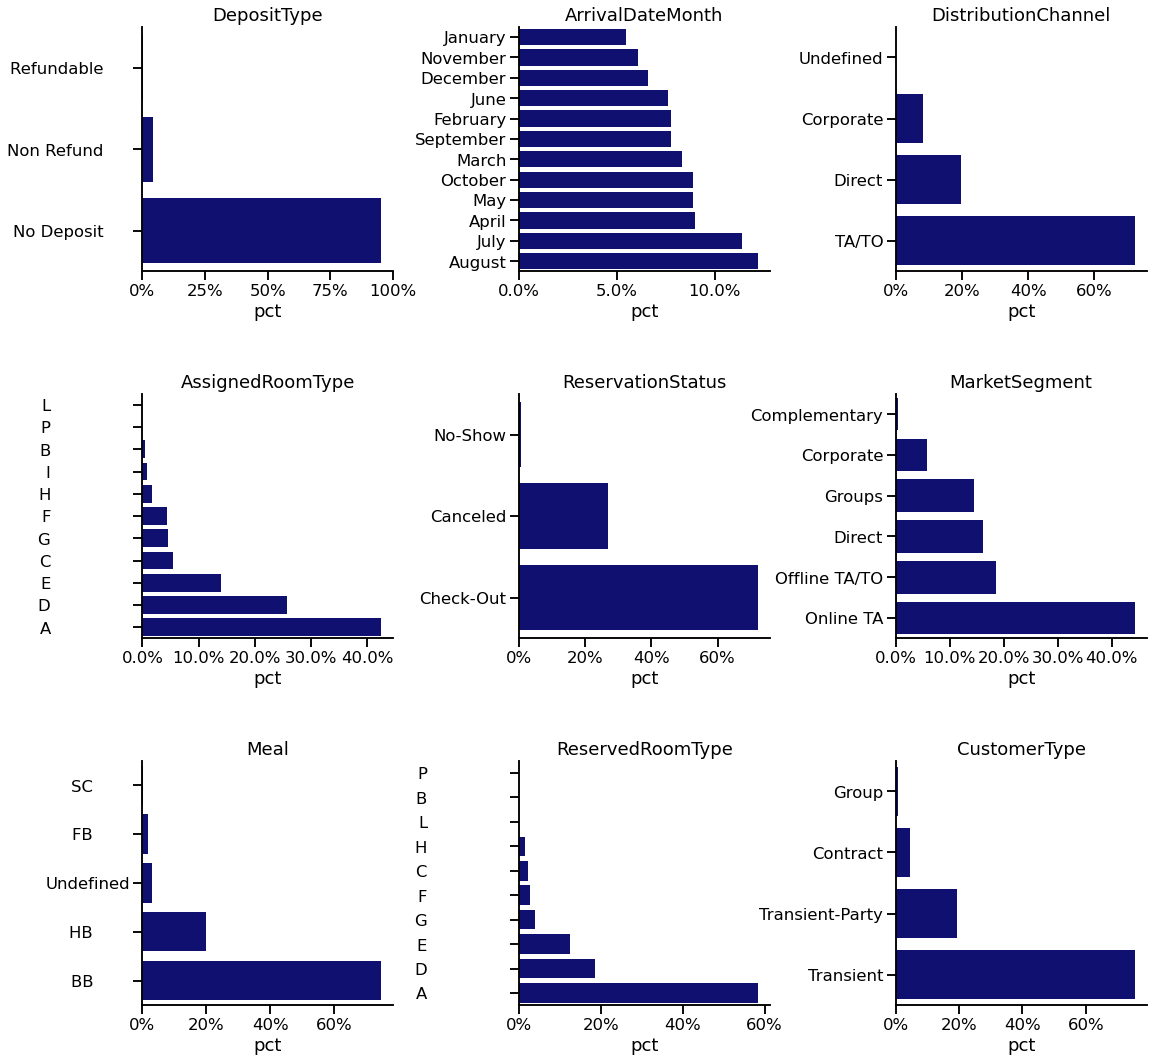

In [28]:
excluded_cols = [
    'IsCanceled','ArrivalDateYear','ArrivalDateWeekNumber',
    'ArrivalDateDayOfMonth','IsRepeatedGuest','BookingChanges',
    'Country','Company','Agent'
]

categorical_cols = [item[0] for item in df_h1.dtypes if (item[1] == 'string')]
categorical_cols = list(set(categorical_cols) - set(excluded_cols))

f, ax = plt.subplots(figsize = (18, 18), ncols = 3, nrows = 3)
plt.subplots_adjust(wspace = .5, hspace = .5)
i = 0
j = 0

for col in categorical_cols:
    agg = df_h1.groupBy(col).count().orderBy('count').toPandas()
    agg['pct'] = agg['count'] / agg['count'].sum()
    
    sns.barplot(
        data = agg,
        y = col,
        x = 'pct',
        orient = 'h',
        color = 'navy',
        ax = ax[i][j]
    )
    
    ax[i][j].set_title(col)
    ax[i][j].set_ylabel('')
    ax[i][j].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1

sns.despine();

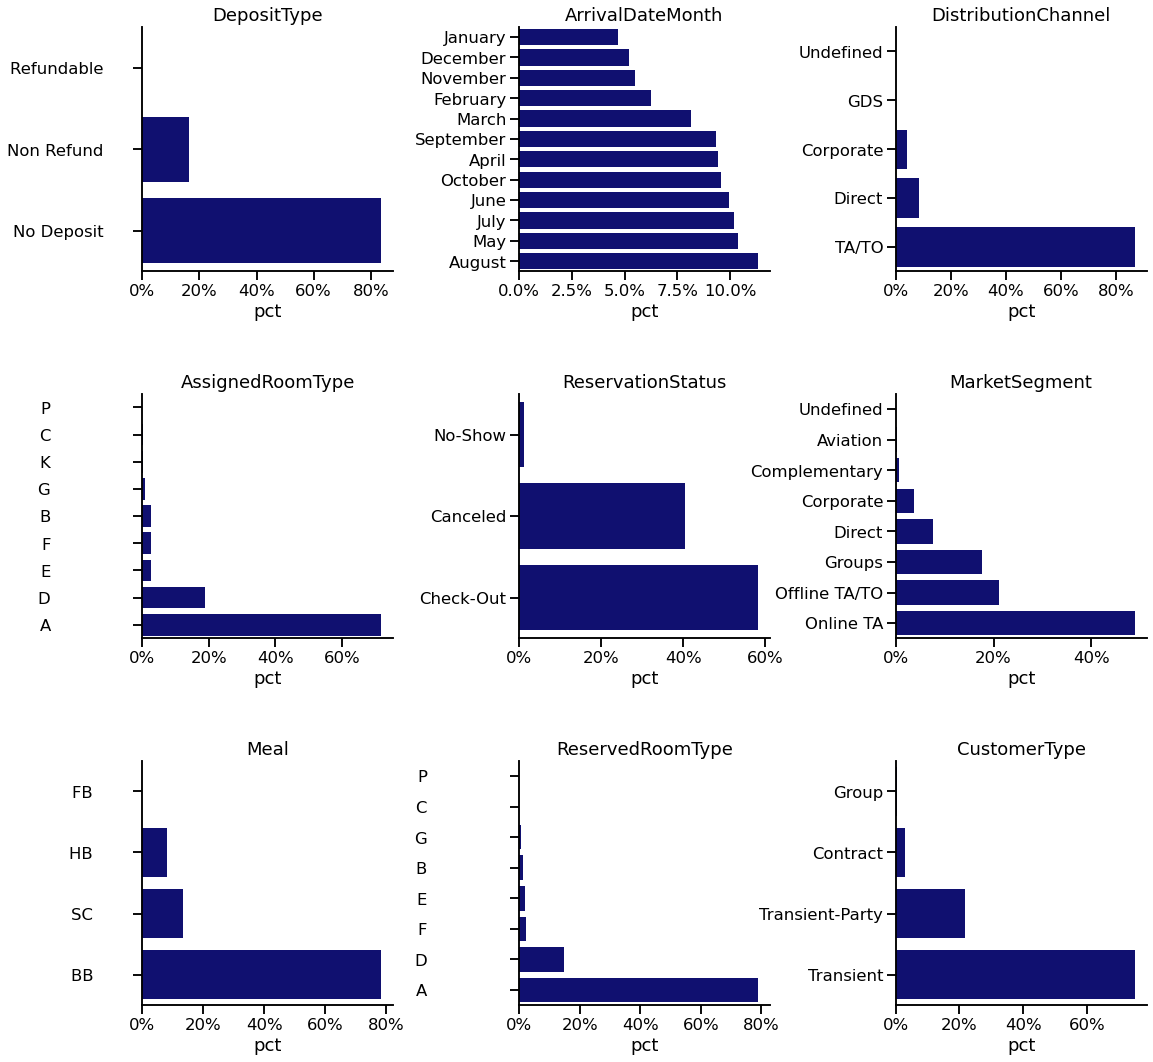

In [29]:
f, ax = plt.subplots(figsize = (18, 18), ncols = 3, nrows = 3)
plt.subplots_adjust(wspace = .5, hspace = .5)
i = 0
j = 0

for col in categorical_cols:
    agg = df_h2.groupBy(col).count().orderBy('count').toPandas()
    agg['pct'] = agg['count'] / agg['count'].sum()
    
    sns.barplot(
        data = agg,
        y = col,
        x = 'pct',
        orient = 'h',
        color = 'navy',
        ax = ax[i][j]
    )
    
    ax[i][j].set_title(col)
    ax[i][j].set_ylabel('')
    ax[i][j].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1

sns.despine();

### 2.4.2. Data error: extreme values and outliers

Assumption: outliers if values are:

- $< Q1 - 1.5 * IQR$, or 
- $> Q3 + 1.5 * IQR$

In [30]:
## create spark dataframes as placeholders to store the results
from pyspark.sql.types import StringType, DoubleType, IntegerType, StructField, StructType

data_schema = [
    StructField('attribute_name', StringType(), nullable = True),
    StructField('count_outliers', IntegerType(), nullable = True),
    StructField('proportion_outliers', DoubleType(), nullable = True)
]

df_outliers_h1 = spark.createDataFrame(
    data = spark.sparkContext.emptyRDD(), 
    schema = StructType(fields = data_schema)
)

df_outliers_h2 = spark.createDataFrame(
    data = spark.sparkContext.emptyRDD(), 
    schema = StructType(fields = data_schema)
)

In [31]:
from pyspark.sql import SQLContext

sql_con = SQLContext(spark)
df_h1.createOrReplaceTempView('df_h1')
df_h2.createOrReplaceTempView('df_h2')

for src in ['df_h1', 'df_h2']:
    for col in sorted(selected_cols):
        QUERY = """
            with get_boundary as (
              select
                percentile_approx({0}, 0.25) as q1
                , percentile_approx({0}, 0.75) as q3
                , percentile_approx({0}, 0.75) - percentile_approx({0}, 0.25) as iqr
                , count(*) as count_total
              from {1}
            )

            select 
              '{0}' as attribute_name
              , sum(
                case 
                  when {0} < (q1 - 1.5*iqr) or {0} > (q3 + 1.5*iqr)
                then 1
                else 0
                end
                  ) as count_outliers
              , sum(
                  case 
                   when {0} < (q1 - 1.5*iqr) or {0} > (q3 + 1.5*iqr)
                  then 1
                  else 0
                  end
                  ) / count_total as proportion_outliers
            from {1}
            cross join get_boundary
            group by 1, count_total, q1, q3, iqr
        """.format(col, src)

        result = sql_con.sql(QUERY)
        
        if 'h1' in src:
            df_outliers_h1 = df_outliers_h1.union(result)
        else:
            df_outliers_h2 = df_outliers_h2.union(result)

In [32]:
df_outliers_h1.show()

+--------------------+--------------+--------------------+
|      attribute_name|count_outliers| proportion_outliers|
+--------------------+--------------+--------------------+
|                 ADR|          1344| 0.03354967548676985|
|              Adults|          8635|  0.2155516724912631|
|              Babies|           548|0.013679480778831752|
|            Children|          3484| 0.08696954568147779|
|   DaysInWaitingList|           255|  0.0063654518222666|
|            LeadTime|           433|0.010808786819770344|
|PreviousBookingsN...|          2032| 0.05072391412880679|
|PreviousCancellat...|          1095|0.027333999001497754|
|RequiredCarParkin...|          5490| 0.13704443334997504|
|   StaysInWeekNights|           232|0.005791313030454319|
|StaysInWeekendNights|           183|0.004568147778332502|
|TotalOfSpecialReq...|          1066|0.026610084872690964|
+--------------------+--------------+--------------------+



In [33]:
df_outliers_h2.show()

+--------------------+--------------+--------------------+
|      attribute_name|count_outliers| proportion_outliers|
+--------------------+--------------+--------------------+
|                 ADR|          3387| 0.04269507122147989|
|              Adults|         21075| 0.26566242279087354|
|              Babies|           369|0.004651455943527039|
|            Children|          5106| 0.06436404890961805|
|   DaysInWaitingList|          3443| 0.04340098323458969|
|            LeadTime|          2576|0.032471952603050545|
|PreviousBookingsN...|          1588|0.020017647800327745|
|PreviousCancellat...|          5389| 0.06793142569015505|
|RequiredCarParkin...|          1926| 0.02427833102231186|
|   StaysInWeekNights|           719|0.009063406025463254|
|StaysInWeekendNights|            82|0.001033656876339342|
|TotalOfSpecialReq...|          1811| 0.02282869028110425|
+--------------------+--------------+--------------------+



In [34]:
del df_outliers_h1, df_outliers_h2

### 2.4.3. Missing values

Notice some differences in the inferred schema, e.g., Children is identified as integer in H1.csv, whereas it is identified as string in H2 (due to null values).

In [35]:
df_h1.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: integer (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Depos

In [36]:
df_h2.printSchema()

root
 |-- IsCanceled: integer (nullable = true)
 |-- LeadTime: integer (nullable = true)
 |-- ArrivalDateYear: integer (nullable = true)
 |-- ArrivalDateMonth: string (nullable = true)
 |-- ArrivalDateWeekNumber: integer (nullable = true)
 |-- ArrivalDateDayOfMonth: integer (nullable = true)
 |-- StaysInWeekendNights: integer (nullable = true)
 |-- StaysInWeekNights: integer (nullable = true)
 |-- Adults: integer (nullable = true)
 |-- Children: string (nullable = true)
 |-- Babies: integer (nullable = true)
 |-- Meal: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- MarketSegment: string (nullable = true)
 |-- DistributionChannel: string (nullable = true)
 |-- IsRepeatedGuest: double (nullable = true)
 |-- PreviousCancellations: integer (nullable = true)
 |-- PreviousBookingsNotCanceled: integer (nullable = true)
 |-- ReservedRoomType: string (nullable = true)
 |-- AssignedRoomType: string (nullable = true)
 |-- BookingChanges: integer (nullable = true)
 |-- Deposi

Null values in string could be encoded as NA, NULL, None, or an empty string.

In [37]:
## NA on Children
df_h2.select('Children').toPandas()['Children'].unique()

array(['0', '1', '2', 'NA', '3'], dtype=object)

In [38]:
## NULL on Country
df_h2.select('Country').toPandas()['Country'].unique()

array(['PRT', 'ITA', 'ESP', 'DEU', 'FRA', 'NLD', 'GBR', 'ROU', 'BRA',
       'SWE', 'AUT', 'AGO', 'BEL', 'CHE', 'NOR', 'RUS', 'ISR', 'IRL',
       'POL', 'CHN', 'USA', 'MAR', 'AUS', 'MOZ', 'TUN', 'DNK', 'MEX',
       'GRC', 'DZA', 'COL', 'LUX', 'CN', 'LVA', 'FIN', 'HRV', 'STP',
       'BGR', 'UKR', 'VEN', 'TWN', 'IRN', 'KOR', 'TUR', 'BLR', 'JPN',
       'CZE', 'HUN', 'AZE', 'KAZ', 'IND', 'NZL', 'IDN', 'LTU', 'LBN',
       'SRB', 'SVN', 'SVK', 'MYS', 'CMR', 'CHL', 'ARG', 'NULL', 'SGP',
       'SEN', 'PER', 'EGY', 'SAU', 'KNA', 'JOR', 'ZAF', 'THA', 'KWT',
       'LKA', 'ALB', 'ETH', 'PHL', 'ARE', 'ECU', 'OMN', 'IRQ', 'AND',
       'CPV', 'MUS', 'HND', 'NGA', 'RWA', 'EST', 'PAK', 'GEO', 'GIB',
       'ZMB', 'QAT', 'KHM', 'HKG', 'MCO', 'BGD', 'ISL', 'UZB', 'URY',
       'IMN', 'TJK', 'ARM', 'MDV', 'NIC', 'GGY', 'BEN', 'MAC', 'CYP',
       'VGB', 'MLT', 'CRI', 'TZA', 'JEY', 'GAB', 'MKD', 'BIH', 'VNM',
       'GHA', 'TMP', 'GLP', 'KEN', 'PRI', 'DOM', 'LIE', 'GNB', 'BHR',
       'MNE', 'UMI',

In [39]:
import pyspark.sql.functions as F
from functools import reduce

def check_missing_values(spark_df):
    """
    Check number of missing values in the columns.
    Non-numeric columns are considered as missing if it contains NA, NULL, None, or an empty string.
    """
    # split numeric and non-numeric columns
    numeric_cols = [item[0] for item in spark_df.dtypes if (item[1] != 'timestamp') & (item[1] != 'string')]
    nonnumeric_cols = [item[0] for item in spark_df.dtypes if (item[1] == 'timestamp') | (item[1] == 'string')]
    
    res_numeric = spark_df.select([
        F.count(
            F.when(
                F.isnan(c) | F.isnull(c),
                c
            )
        ).alias(c) for c in numeric_cols
    ])
    
    res_numeric_tranposed = reduce(
        lambda a, b: a.union(b),
        (
            res_numeric.select(F.lit(c).alias("attribute_name"), F.col(c).alias("count_missing")) 
            for c in numeric_cols
        )
    )
    
    res_nonnumeric = spark_df.select([
        F.count(
            F.when(
                F.col(c).isin(['NA','NULL','None','']),
                   c)
        ).alias(c) for c in nonnumeric_cols
    ])
    
    res_nonnumeric_tranposed = reduce(
        lambda a, b: a.union(b),
        (
            res_nonnumeric.select(F.lit(c).alias("attribute_name"), F.col(c).alias("count_missing")) 
            for c in nonnumeric_cols
        )
    )
    
    df_result = res_numeric_tranposed.union(res_nonnumeric_tranposed)
    df_result = df_result.withColumn(
        'percentage_missing',
        F.round(df_result['count_missing'] / spark_df.count() * 100, 3)
    )
    return df_result

In [40]:
df_missing_h1 = check_missing_values(df_h1)
df_missing_h2 = check_missing_values(df_h2)

In [41]:
N = len(df_h1.columns)
df_missing_h1.select(['attribute_name', 'count_missing', 'percentage_missing']).show(n=N)
df_missing_h2.select(['attribute_name', 'count_missing', 'percentage_missing']).show(n=N)

+--------------------+-------------+------------------+
|      attribute_name|count_missing|percentage_missing|
+--------------------+-------------+------------------+
|          IsCanceled|            0|               0.0|
|            LeadTime|            0|               0.0|
|     ArrivalDateYear|            0|               0.0|
|ArrivalDateWeekNu...|            0|               0.0|
|ArrivalDateDayOfM...|            0|               0.0|
|StaysInWeekendNights|            0|               0.0|
|   StaysInWeekNights|            0|               0.0|
|              Adults|            0|               0.0|
|            Children|            0|               0.0|
|              Babies|            0|               0.0|
|     IsRepeatedGuest|            0|               0.0|
|PreviousCancellat...|            0|               0.0|
|PreviousBookingsN...|            0|               0.0|
|      BookingChanges|            0|               0.0|
|   DaysInWaitingList|            0|            